# Segmenting and Clustering Neighboroods in Toronto

## Getting and cleaning the data

### 1) Scraping the data from the web

No need to use Beautiful Soup to import the dataframe, as Pandas has a useful `read.html` function which returns a list containing all the tables in a page, already converted into DataFrames.

In [150]:
import pandas as pd

In [151]:
url  = 'https://www.zipcodesonline.com/2020/06/postal-code-of-toronto-in-2020.html#:~:text=INTRODUCTION%20%20%20%20SL.%20NO.%20%20,%20%20Etobicoke%20%2054%20more%20rows'

In [152]:
#resetting to default the number of rows displayed on output
pd.reset_option("display.max_rows")
dfs = pd.read_html(url, header=0)
dfs

[Empty DataFrame
 Columns: [Postal Code of Toronto]
 Index: [],
      SL. NO.      NEIGHBOURHOOD POSTAL CODES          DISTRICT
 0        NaN                NaN          NaN               NaN
 1        1.0           Adelaide          M5H  Downtown Toronto
 2        2.0    Agincourt North          M1V       Scarborough
 3        3.0          Agincourt          M1S       Scarborough
 4        4.0     Albion Gardens          M9V         Etobicoke
 ..       ...                ...          ...               ...
 201    201.0  Woodbine Gardens,          M4B         East York
 202    202.0   Woodbine Heights          M4C         East York
 203    203.0    York Mills West          M2P        North York
 204    204.0         York Mills          M2L        North York
 205    205.0          Yorkville          M5R   Central Toronto
 
 [206 rows x 4 columns]]

The table is indexed as the first data frame in the list.

In [153]:
toronto_pc = dfs[1]
toronto_pc.to_csv('toronto_pc.csv')
toronto_pc

,SL. NO.,NEIGHBOURHOOD,POSTAL CODES,DISTRICT
0,NaN,NaN,NaN,NaN
1,1.0,Adelaide,M5H,Downtown Toronto
2,2.0,Agincourt North,M1V,Scarborough
3,3.0,Agincourt,M1S,Scarborough
4,4.0,Albion Gardens,M9V,Etobicoke
...,...,...,...,...
201,201.0,"Woodbine Gardens,",M4B,East York
202,202.0,Woodbine Heights,M4C,East York
203,203.0,York Mills West,M2P,North York
204,204.0,York Mills,M2L,North York


In [154]:
toronto_pc.dropna(inplace=True)
toronto_pc.drop(columns='SL. NO.', inplace=True)
toronto_pc.rename(columns={'DISTRICT' : 'Borough', 'NEIGHBOURHOOD' : 'Neighbourhood', 'DISTRICT' : 'Borough', 'POSTAL CODES': 'Postal Code'},
                 inplace=True)


In [155]:
#cleaning the index 
# the parameter drop =True avoids to create a new index columns with the old values;
toronto_pc.reset_index(inplace = True, drop = True) 
toronto_pc

,Neighbourhood,Postal Code,Borough
0,Adelaide,M5H,Downtown Toronto
1,Agincourt North,M1V,Scarborough
2,Agincourt,M1S,Scarborough
3,Albion Gardens,M9V,Etobicoke
4,Alderwood,M8W,Etobicoke
...,...,...,...
200,"Woodbine Gardens,",M4B,East York
201,Woodbine Heights,M4C,East York
202,York Mills West,M2P,North York
203,York Mills,M2L,North York


### 2) Fetching Coordinates

Since the geocoder package seems to show many issues, I will use the package pgeocode to import the coordinates. After setting the local ('ca'), this library returns a Pandas Data Frame in answer to a Postal Code query. From this data frame we will select only the data pertaining latitude and longitude.

In [156]:
import pgeocode 

nomi = pgeocode.Nominatim('ca')

Latitude = []
Longitude = []

for pc in toronto_pc['Postal Code']:
    if len(pc) > 3:
        pc = pc[0:3]
    query = nomi.query_postal_code(pc)
    Latitude.append(query.latitude)
    Longitude.append(query.longitude)

In [157]:
#assigning the coordinates to new columns in the existing dataframe
toronto_pc.loc[:,'Latitude'] = Latitude
toronto_pc.loc[:,'Longitude'] = Longitude
toronto_pc, toronto_pc.shape

(         Neighbourhood Postal Code           Borough  Latitude  Longitude
 0             Adelaide         M5H  Downtown Toronto   43.6496   -79.3833
 1      Agincourt North         M1V       Scarborough   43.8177   -79.2819
 2            Agincourt         M1S       Scarborough   43.7946   -79.2644
 3       Albion Gardens         M9V         Etobicoke   43.7432   -79.5876
 4            Alderwood         M8W         Etobicoke   43.6021   -79.5402
 ..                 ...         ...               ...       ...        ...
 200  Woodbine Gardens,         M4B         East York   43.7063   -79.3094
 201   Woodbine Heights         M4C         East York   43.6913   -79.3116
 202    York Mills West         M2P        North York   43.7500   -79.3978
 203         York Mills         M2L        North York   43.7547   -79.3764
 204          Yorkville         M5R   Central Toronto   43.6736   -79.4035
 
 [205 rows x 5 columns],
 (205, 5))

We got just one Nan:

In [158]:
toronto_pc[toronto_pc.isnull().any(axis = 1)]

,Neighbourhood,Postal Code,Borough,Latitude,Longitude
18,Canada Post Gateway Processing Centre,M7R,Mississauga,NaN,NaN


In [159]:
#set the values
toronto_pc.dropna(inplace=True)

In [160]:
toronto_pc.isnull().any(axis = 0)

Neighbourhood    False
Postal Code      False
Borough          False
Latitude         False
Longitude        False
dtype: bool

In [161]:
pd.set_option("max_rows", 103)
toronto_pc.sort_values(['Borough', 'Neighbourhood'])

,Neighbourhood,Postal Code,Borough,Latitude,Longitude
33,Davisville,M4S,Central Toronto,43.7020,-79.3853
32,Davisville North,M4P,Central Toronto,43.7135,-79.3887
34,Deer Park,M4V,Central Toronto,43.6861,-79.4025
51,Forest Hill North & West,M5P,Central Toronto,43.6966,-79.4120
52,Forest Hill Road Park,M5P,Central Toronto,43.6966,-79.4120
...,...,...,...,...,...
79,Keelsdale and Silverthorn,M6M,York,43.6934,-79.4857
110,Mount Dennis,M6M,York,43.6934,-79.4857
145,Runnymede,M6N,York,43.6748,-79.4839
173,The Junction North,M6N,York,43.6748,-79.4839


Some duplicated entries in the Neighborhood columns surface after sorting. For example we have four different entries for "Downsview", which in fact correspond to four different postal coded. For the scope of this notebook, we can retain only one entry per Neighborhood. Also, the naming of some Neighborhoods is slightly ambiguos, since often different toponyms are listed togther on the same line. Unfortunately without further inquiry about the city urban plan and in absence of another data source we have to do with that.

In [162]:
toronto_pc.describe(include='all')
toronto_pc[toronto_pc['Neighbourhood'] == 'Downsview']
# there seems to be 4 entries for Downsview , though the coordinates are different.

,Neighbourhood,Postal Code,Borough,Latitude,Longitude
40,Downsview,"M3M,M3L,M3N",North York,43.7319,-79.4928
42,Downsview,M3K,North York,43.7390,-79.4692


In [163]:
toronto_pc[toronto_pc.duplicated(['Borough','Neighbourhood'], keep=False)]

,Neighbourhood,Postal Code,Borough,Latitude,Longitude
40,Downsview,"M3M,M3L,M3N",North York,43.7319,-79.4928
42,Downsview,M3K,North York,43.7390,-79.4692
92,Lawrence Park,M4R,Central Toronto,43.7143,-79.4065
93,Lawrence Park,M4N,Central Toronto,43.7301,-79.3935
156,St. James Town,M4X,Downtown Toronto,43.6684,-79.3689
157,St. James Town,M5C,Downtown Toronto,43.6513,-79.3756


In [164]:
pd.reset_option('max_rows')
toronto_pc = toronto_pc.drop_duplicates(['Borough', 'Neighbourhood'])

We have managed to drop 3 duplicate entries.

Let's examine how then neighbourhoods are distributed by borough, that will be useful later to decide how many cluster do we need:

In [165]:
print(toronto_pc['Borough'].value_counts())


Etobicoke           46
Scarborough         37
Downtown Toronto    36
North York          28
Central Toronto     17
West Toronto        13
East York            9
York                 8
East Toronto         6
North York,          1
Name: Borough, dtype: int64


## Clustering

Importing the libraries needed for visualization and clustering:

In [166]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
#library needed to get Toronto coordinates:
!pip install geopy
from geopy.geocoders import Nominatim
print('Libraries imported.')

Libraries imported.


In order to define an instance of the geocoder, we need to define a user_agent:

In [167]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Creating a map of Toronto with neighborhoods superimposed:


In [168]:
toronto_map= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_pc['Latitude'], toronto_pc['Longitude'], toronto_pc['Borough'], toronto_pc['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

We are now ready to set up the Foursquare API to make queries.

 ### 1) Defining Foursquare API credentials and parameters

Since I believe working with the URL as suggested in the course to make an API is overtly complicated, I decided to use this line of code (found here : https://developer.foursquare.com/docs/places-api/getting-started/). In place of filling the URL directly with the parameters, we will create a dictionary of the parameters which we will place inside a GET request (much neater).

In [169]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='TDUMTXN0WG4EZFIPJBH5FUG1YXLZCMFQXJTWNEZ2RSJ14W3S',
client_secret='1FEIJEA0NXDXAONICQ55E53CPLUUWHQ4FNDWJIP0V1TGO1XU',
v='20180323',
ll='43.6534817,-79.3839347',
limit=1
)
#testing a query
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

I willl borrow the function **getNearbyVenues**  used in the Lab to loop 'explore' queries through the neighboroods and get the corresponding venues.

In [170]:
#since we have 103 different neighboroods, we are setting the query limit to 50 so as not to exceed tha API call limit
params['limit'] = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #modify the coordinates
        params['ll'] = str(lat)+','+str(lng)
            
        # make the GET request
        results = requests.get(url, params).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [171]:
toronto_venues = getNearbyVenues(toronto_pc.Neighbourhood, toronto_pc.Latitude, toronto_pc.Longitude, radius=500)

Adelaide
Agincourt North
Agincourt
Albion Gardens
Alderwood
Bathurst Manor
Bathurst Quay
Bayview Village
Beaumond Heights
Bedford Park, ,
Berczy Park
Birch Cliff
Bloordale Gardens
Broadview North
Brockton
Business reply mail Processing Centre
Cabbagetown
Caledonia Fairbanks
Cedarbrae
Central Bay Street
Chinatown
Christie
Church and Wellesley
Clairlea
Clarks Corners
Cliffcrest
Cliffside West
Cliffside
Cloverdale
CN Tower
Commerce Court
Davisville North
Davisville
Deer Park
Del Ray
Design Exchange
Don Mills
Dorset Park
Dovercourt Village
Downsview
Downsview North
Dufferin
East Birchmount Park
East Toronto
Emery
Eringate
Exhibition Place
Fairview
First Canadian Place
Forest Hill North & West
Forest Hill Road Park
Forest Hill SE
Garden District
Glencairn
Golden Mile
Grange Park
Guildwood
Harbord
Harbourfront East
Harbourfront West
Harbourfront
Henry Farm
High Park
Highland Creek
Hillcrest Village
Humber Bay Shores
Humber Bay, Etobicoke
Humber Summit
Humber Valley Village
Humbergate
Humberl

In [172]:

print(toronto_venues['Neighborhood'].value_counts())
print()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

Runnymede            200
Chinatown            100
North Park           100
Bathurst Quay        100
Kensington Market    100
                    ... 
Toronto Islands       73
Harbourfront East     73
Union Station         73
Leaside               65
Queen's Park          55
Name: Neighborhood, Length: 200, dtype: int64

There are 333 uniques categories.


### 2) Analyzing the most frequent venues

In [178]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] =toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
toronto_onehot.shape

(19814, 333)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [180]:
pd.reset_option("max_rows")
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Adelaide,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.02,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0
1,Agincourt,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.020000,0.00,0.0,0.0,0.01,0.000000,0.0,0.00,0.0
2,Agincourt North,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.040000,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0
3,Albion Gardens,0.0,0.0,0.0,0.000000,0.010989,0.0,0.0,0.00,0.0,...,0.0,0.010989,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0
4,Alderwood,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.010000,0.01,0.0,0.0,0.00,0.000000,0.0,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,"Woodbine Gardens,",0.0,0.0,0.0,0.022222,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.011111,0.0,0.00,0.0
196,Woodbine Heights,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.02,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0
197,York Mills,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0
198,York Mills West,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0


#### Let's print each neighborhood along with the top 5 most common venues


In [181]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [182]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [183]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall
1,Agincourt,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy
2,Agincourt North,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket
3,Albion Gardens,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner
4,Alderwood,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store


### 3) Cluster Neighborhoods


C:\Users\teore\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


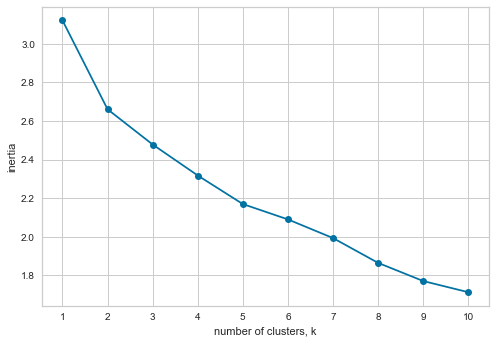

In [184]:
#a good cluster has tight clusters(low inertia) but also not too many clusters! A good rule of thumb is choosing the "elbow" value in the inertia plot

#drop the neighborhood(non-numeric) column from the data:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

import matplotlib.pyplot as plt
ks = range(1, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(toronto_grouped_clustering)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()   

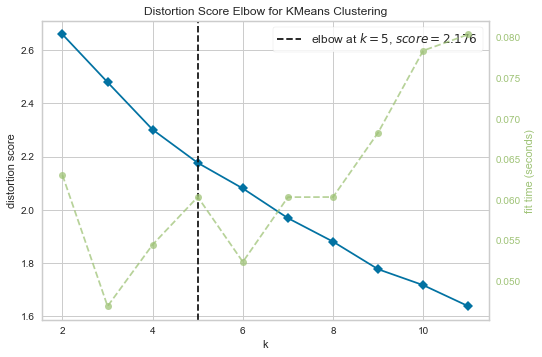

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [256]:

from yellowbrick.cluster.elbow import KElbowVisualizer
model = KMeans()
visualizer= KElbowVisualizer(model, k=11)
visualizer.fit(toronto_grouped_clustering)
visualizer.show()

Even if KElbow visualizer reports 7 as the optimal k-score, this result is only circumstantial; if we were to run the analysis many time we would obtain every time a different result. We will run _k_-means to cluster the neighborhood into 5 clusters, since there is no clear optimal value and it seems a reasonable choice.


In [257]:
from sklearn.cluster import KMeans

# set number of clusters, 1 per borough
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, algorithm='full').fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(kmeans.inertia_)



C:\Users\teore\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


[1 0 0 2 4 4 1 2 2 4]
2.1826767517663455


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [258]:
# add clustering labels
neighborhoods_venues_sorted.loc[:,'Cluster Labels'] = kmeans.labels_
pd.reset_option('max_rows')
display(neighborhoods_venues_sorted)
toronto_merged = toronto_pc[(toronto_pc['Neighbourhood'] !=  'First Canadian Place, Underground city') & (toronto_pc['Neighbourhood'] != 
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East")]

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Adelaide,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1
1,Agincourt,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy,0
2,Agincourt North,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket,0
3,Albion Gardens,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner,2
4,Alderwood,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store,4
...,...,...,...,...,...,...,...,...,...,...,...,...
195,"Woodbine Gardens,",Coffee Shop,Grocery Store,Sandwich Place,Japanese Restaurant,Park,Middle Eastern Restaurant,Restaurant,Department Store,Discount Store,Fast Food Restaurant,4
196,Woodbine Heights,Coffee Shop,Gastropub,Café,Bakery,Pub,Brewery,BBQ Joint,Grocery Store,Breakfast Spot,Indian Restaurant,3
197,York Mills,Coffee Shop,Japanese Restaurant,Supermarket,Burger Joint,Café,Restaurant,Park,Grocery Store,Thai Restaurant,Sandwich Place,4
198,York Mills West,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Grocery Store,Burger Joint,Ice Cream Shop,Ramen Restaurant,Bakery,Fried Chicken Joint,4


,Neighbourhood,Postal Code,Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Adelaide,M5H,Downtown Toronto,43.6496,-79.3833,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1
1,Agincourt North,M1V,Scarborough,43.8177,-79.2819,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket,0
2,Agincourt,M1S,Scarborough,43.7946,-79.2644,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy,0
3,Albion Gardens,M9V,Etobicoke,43.7432,-79.5876,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner,2
4,Alderwood,M8W,Etobicoke,43.6021,-79.5402,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store,4


Two clusters present NaN values

In [259]:
toronto_merged = toronto_merged.dropna()
toronto_merged

,Neighbourhood,Postal Code,Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Adelaide,M5H,Downtown Toronto,43.6496,-79.3833,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1
1,Agincourt North,M1V,Scarborough,43.8177,-79.2819,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket,0
2,Agincourt,M1S,Scarborough,43.7946,-79.2644,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy,0
3,Albion Gardens,M9V,Etobicoke,43.7432,-79.5876,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner,2
4,Alderwood,M8W,Etobicoke,43.6021,-79.5402,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,"Woodbine Gardens,",M4B,East York,43.7063,-79.3094,Coffee Shop,Grocery Store,Sandwich Place,Japanese Restaurant,Park,Middle Eastern Restaurant,Restaurant,Department Store,Discount Store,Fast Food Restaurant,4
201,Woodbine Heights,M4C,East York,43.6913,-79.3116,Coffee Shop,Gastropub,Café,Bakery,Pub,Brewery,BBQ Joint,Grocery Store,Breakfast Spot,Indian Restaurant,3
202,York Mills West,M2P,North York,43.7500,-79.3978,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Grocery Store,Burger Joint,Ice Cream Shop,Ramen Restaurant,Bakery,Fried Chicken Joint,4
203,York Mills,M2L,North York,43.7547,-79.3764,Coffee Shop,Japanese Restaurant,Supermarket,Burger Joint,Café,Restaurant,Park,Grocery Store,Thai Restaurant,Sandwich Place,4


Finally, let's visualize the resulting clusters :


In [260]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype('int')
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [261]:
toronto_merged[toronto_merged['Cluster Labels']==3]
toronto_venues.groupby('Neighborhood').agg({'Venue Category':'count'}).sort_values('Venue Category')

,Venue Category
Neighborhood,
Queen's Park,55
Leaside,65
Union Station,73
Harbourfront East,73
Toronto Islands,73
...,...
Ionview,100
Island airport,100
Hillcrest Village,100


### 4) Examine Clusters


Finally let's check the discriminating categories between each cluster, based on the first three most common venues:

In [262]:
toronto_merged.groupby('Cluster Labels')[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']].describe()

1st Most Common Venue                                  \
                               count unique                 top freq   
Cluster Labels                                                         
0                                 20      2  Chinese Restaurant   15   
1                                 28      5         Coffee Shop   17   
2                                 37      2         Coffee Shop   31   
3                                 64      7                Café   18   
4                                 52      7         Coffee Shop   36   

               2nd Most Common Venue                                    \
                               count unique                   top freq   
Cluster Labels                                                           
0                                 20      6                Bakery    6   
1                                 28      8           Yoga Studio    7   
2                                 37     10  Fast Food Restaurant    8   
3                                 64     10           Coffee Shop   28   
4                                 52     10           Coffee Shop    9   

               3rd Most Common Venue                               
                               count unique              top freq  
Cluster Labels                                                     
0                                 20      6  Bubble Tea Shop    6  
1                                 28      7             Café   16  
2                                 37      8   Sandwich Place   14  
3                                 64     12             Park   16  
4                                 52     15    Grocery Store    9

In [263]:
toronto_merged[toronto_merged['Cluster Labels']==1]

,Neighbourhood,Postal Code,Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Adelaide,M5H,Downtown Toronto,43.6496,-79.3833,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1
6,Bathurst Quay,M5V,Downtown Toronto,43.6404,-79.3995,Coffee Shop,Yoga Studio,Café,Gym,Park,Italian Restaurant,Sandwich Place,Dessert Shop,French Restaurant,Dog Run,1
10,Berczy Park,M5E,Downtown Toronto,43.6456,-79.3754,Coffee Shop,Hotel,Restaurant,Beer Bar,Seafood Restaurant,Japanese Restaurant,Bakery,Cocktail Bar,Café,Gym,1
20,Central Bay Street,M5G,Downtown Toronto,43.6564,-79.3860,Coffee Shop,Clothing Store,Café,Art Gallery,Diner,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Plaza,Cosmetics Shop,1
23,Church and Wellesley,M4Y,Downtown Toronto,43.6656,-79.3830,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Liquor Store,Diner,Salad Place,Café,Bookstore,1
30,CN Tower,M5V,Downtown Toronto,43.6404,-79.3995,Coffee Shop,Yoga Studio,Café,Gym,Park,Italian Restaurant,Sandwich Place,Dessert Shop,French Restaurant,Dog Run,1
31,Commerce Court,M5L,Downtown Toronto,43.6492,-79.3823,Hotel,Coffee Shop,Café,Gym,Japanese Restaurant,Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,1
36,Design Exchange,M5K,Downtown Toronto,43.6469,-79.3823,Coffee Shop,Hotel,Café,Asian Restaurant,Japanese Restaurant,American Restaurant,Gym,Seafood Restaurant,Concert Hall,Steakhouse,1
50,First Canadian Place,M5X,Downtown Toronto,43.6492,-79.3823,Hotel,Coffee Shop,Café,Gym,Japanese Restaurant,Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,1
60,Harbourfront East,M5J,Downtown Toronto,43.6230,-79.3936,Park,Boat or Ferry,Coffee Shop,Café,Gym,Baseball Stadium,Scenic Lookout,Pizza Place,Aquarium,Music Venue,1


In [264]:
toronto_merged.head()

,Neighbourhood,Postal Code,Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Adelaide,M5H,Downtown Toronto,43.6496,-79.3833,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1
1,Agincourt North,M1V,Scarborough,43.8177,-79.2819,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket,0
2,Agincourt,M1S,Scarborough,43.7946,-79.2644,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy,0
3,Albion Gardens,M9V,Etobicoke,43.7432,-79.5876,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner,2
4,Alderwood,M8W,Etobicoke,43.6021,-79.5402,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store,4


In [265]:
df_labels = pd.crosstab(toronto_merged['Cluster Labels'], toronto_merged['1st Most Common Venue'])
df_labels

1st Most Common Venue,Bakery,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Furniture / Home Store,Greek Restaurant,Hotel,Italian Restaurant,Korean Restaurant,Middle Eastern Restaurant,Park,Restaurant,Supermarket,Zoo Exhibit
Cluster Labels,,,,,,,,,,,,,,,
0,0,0,15,0,5,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,17,0,0,4,3,0,0,3,0,0,0
2,0,0,0,0,31,0,0,0,0,0,0,0,0,0,6
3,8,18,0,0,17,0,2,0,12,0,0,4,3,0,0
4,0,0,0,2,36,5,0,4,0,2,2,0,0,1,0


In [266]:
df_lt = df_labels.transpose()
df_lt["total"] = df_lt.sum(axis="columns")
df_lt = df_lt.sort_values("total", ascending=False)
df_lt

Cluster Labels,0,1,2,3,4,total
1st Most Common Venue,,,,,,
Coffee Shop,5,17,31,17,36,106
Café,0,1,0,18,0,19
Chinese Restaurant,15,0,0,0,0,15
Italian Restaurant,0,3,0,12,0,15
Bakery,0,0,0,8,0,8
Hotel,0,4,0,0,4,8
Park,0,3,0,4,0,7
Zoo Exhibit,0,0,6,0,0,6
Furniture / Home Store,0,0,0,0,5,5


In [267]:
#dropping the 'total' colum before plotting
df_lt = df_lt.drop("total",axis=1)

In [268]:
df_lt[0]

1st Most Common Venue
Coffee Shop                   5
Café                          0
Chinese Restaurant           15
Italian Restaurant            0
Bakery                        0
Hotel                         0
Park                          0
Zoo Exhibit                   0
Furniture / Home Store        0
Restaurant                    0
Clothing Store                0
Greek Restaurant              0
Korean Restaurant             0
Middle Eastern Restaurant     0
Supermarket                   0
Name: 0, dtype: int64

<AxesSubplot:xlabel='1st Most Common Venue'>

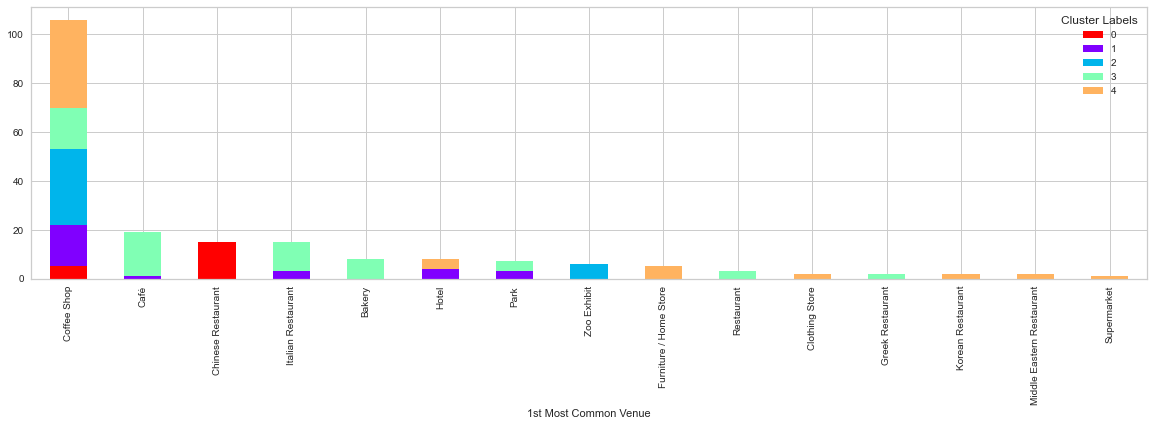

In [269]:
df_lt.plot(kind='bar',figsize=(20,5), rot=90, stacked=True, color=[rainbow[i] for i in df_lt.columns.values - 1])

In [270]:
vc = toronto_merged[["Cluster Labels", "1st Most Common Venue"]].value_counts()


In [271]:
type(vc)

pandas.core.series.Series

In [272]:
vc = vc.sort_index(level=0)
vc


Cluster Labels  1st Most Common Venue    
0               Chinese Restaurant           15
                Coffee Shop                   5
1               Café                          1
                Coffee Shop                  17
                Hotel                         4
                Italian Restaurant            3
                Park                          3
2               Coffee Shop                  31
                Zoo Exhibit                   6
3               Bakery                        8
                Café                         18
                Coffee Shop                  17
                Greek Restaurant              2
                Italian Restaurant           12
                Park                          4
                Restaurant                    3
4               Clothing Store                2
                Coffee Shop                  36
                Furniture / Home Store        5
                Hotel                         

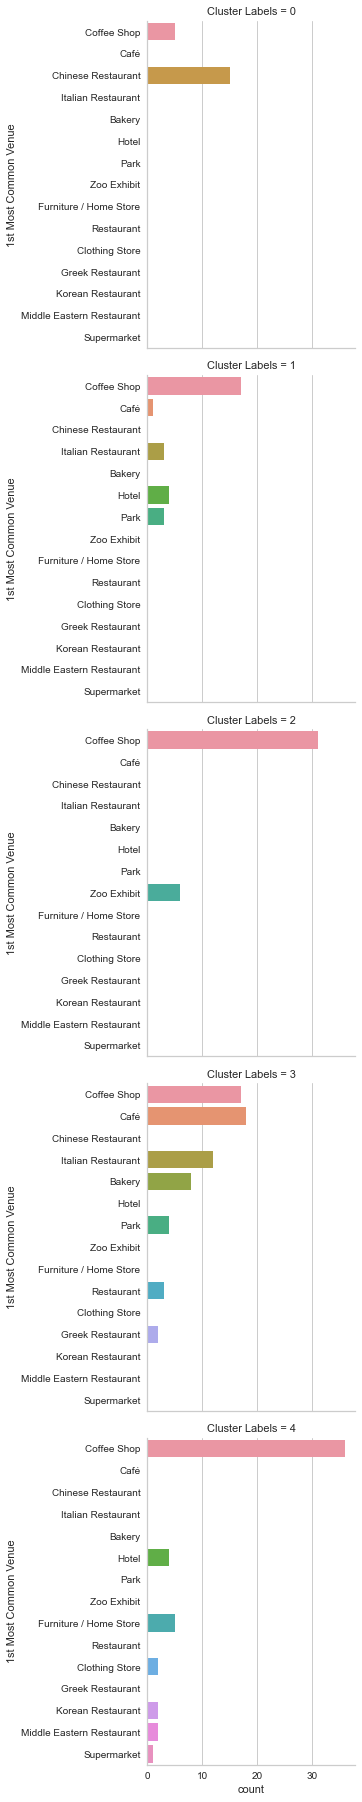

In [273]:
#experimenting with seaborn
import seaborn as sns
sns.catplot(y='1st Most Common Venue', data = toronto_merged, kind='count', order=df_lt.index, row='Cluster Labels')


## Hierarchical Clustering

In [275]:
samples = toronto_grouped.drop(columns= 'Neighborhood').reset_index(drop=True).values
neighborhoods = toronto_grouped.Neighborhood.reset_index(drop=True).values
display(samples, neighborhoods)

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

array(['Adelaide', 'Agincourt', 'Agincourt North', 'Albion Gardens',
       'Alderwood', 'Bathurst Manor', 'Bathurst Quay', 'Bayview Village',
       'Beaumond Heights', 'Bedford Park, ,', 'Berczy Park',
       'Birch Cliff', 'Bloordale Gardens', 'Broadview North', 'Brockton',
       'Business reply mail Processing Centre', 'CN Tower', 'Cabbagetown',
       'Caledonia Fairbanks', 'Cedarbrae', 'Central Bay Street',
       'Chinatown', 'Christie', 'Church and Wellesley', 'Clairlea',
       'Clarks Corners', 'Cliffcrest', 'Cliffside', 'Cliffside West',
       'Cloverdale', 'Commerce Court', 'Davisville', 'Davisville North',
       'Deer Park', 'Del Ray', 'Design Exchange', 'Don Mills',
       'Dorset Park', 'Dovercourt Village', 'Downsview',
       'Downsview North', 'Dufferin', 'East Birchmount Park',
       'East Toronto', 'Emery', 'Eringate', 'Exhibition Place',
       'Fairview', 'First Canadian Place', 'Forest Hill North & West',
       'Forest Hill Road Park', 'Forest Hill SE', 'Gar

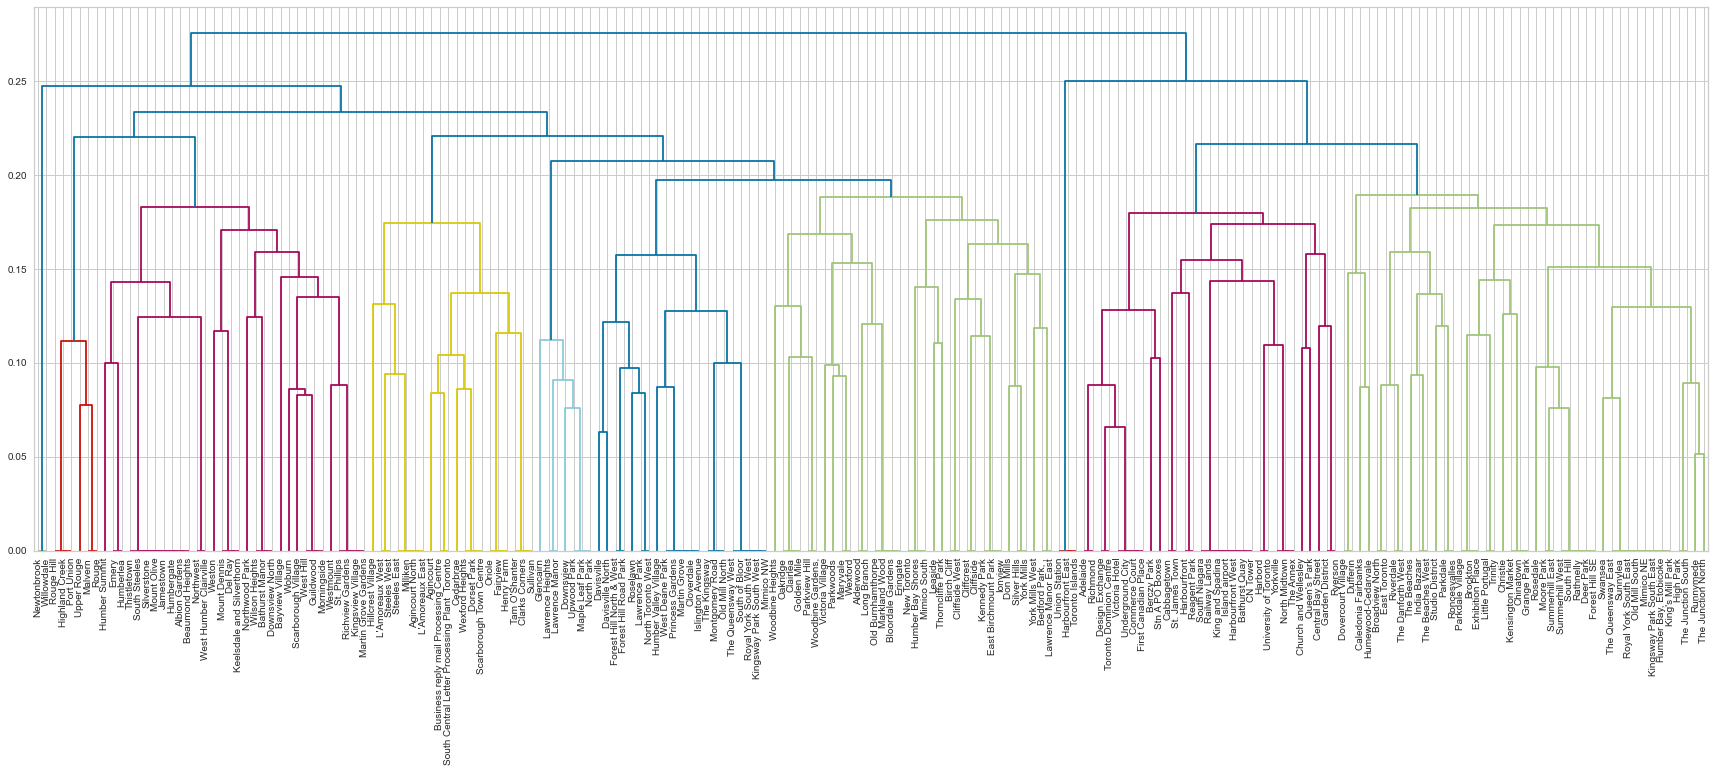

In [276]:
from scipy.cluster.hierarchy import linkage, dendrogram
mergings = linkage(samples, method='complete')
fig, ax = plt.subplots(figsize=(30, 10))
dendrogram(mergings, labels=neighborhoods, ax=ax, leaf_font_size = 10)
plt.show()




In order to compare the labels with the results of kmeans, we will "cut" the dendrogram at 0.23, to obtain 5 values.

In [277]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(mergings, 0.23, criterion='distance')

In [278]:
labels

array([5, 3, 3, 2, 3, 2, 5, 2, 2, 3, 5, 3, 3, 5, 5, 3, 5, 5, 5, 3, 5, 5,
       5, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 2, 5, 3, 3, 5, 3, 2, 5, 3, 5,
       2, 3, 5, 3, 5, 3, 3, 5, 5, 3, 3, 5, 2, 5, 5, 4, 5, 3, 5, 2, 3, 3,
       5, 2, 3, 2, 2, 5, 5, 3, 5, 3, 2, 2, 3, 5, 5, 5, 2, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 3, 2, 3, 3, 3, 2, 3, 3, 5, 3, 3, 3, 5, 2, 2, 2, 3,
       1, 5, 3, 3, 2, 2, 3, 3, 3, 5, 3, 5, 5, 3, 3, 2, 3, 5, 5, 5, 5, 5,
       2, 5, 5, 5, 3, 2, 2, 5, 3, 5, 5, 3, 2, 3, 2, 3, 5, 5, 2, 3, 5, 2,
       3, 3, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 3, 5, 3, 2, 3, 5,
       4, 5, 5, 4, 5, 2, 3, 5, 3, 3, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 3, 3,
       3, 5], dtype=int32)

In [279]:
pairs = pd.DataFrame({'HClabels': labels, 'Neighbourhood': neighborhoods})
pd.reset_option('display.max_rows')
display(pairs.sort_values('HClabels'))

,HClabels,Neighbourhood
192,1,Willowdale
110,1,Newtonbrook
77,2,Keelsdale and Silverthorn
125,2,Port Union
186,2,West Hill
...,...,...
74,5,Island airport
72,5,India Bazaar
71,5,Humewood-Cedarvale
62,5,High Park


<AxesSubplot:>

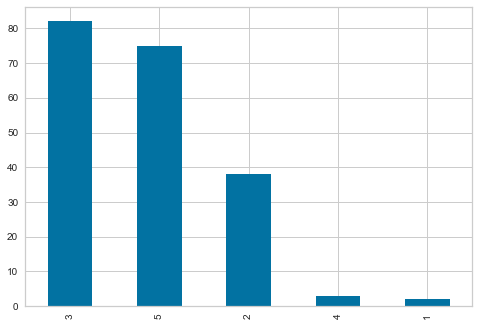

In [280]:
pairs['HClabels'].value_counts().plot(kind='bar')

In [281]:
toronto_labels = pd.merge(toronto_merged, pairs, on ="Neighbourhood")
toronto_labels

,Neighbourhood,Postal Code,Borough,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,HClabels
0,Adelaide,M5H,Downtown Toronto,43.6496,-79.3833,Coffee Shop,Hotel,Café,Restaurant,Clothing Store,Seafood Restaurant,Theater,Gym,Italian Restaurant,Concert Hall,1,5
1,Agincourt North,M1V,Scarborough,43.8177,-79.2819,Chinese Restaurant,Bakery,Bubble Tea Shop,Sandwich Place,Coffee Shop,Vietnamese Restaurant,Noodle House,Pharmacy,Bank,Supermarket,0,3
2,Agincourt,M1S,Scarborough,43.7946,-79.2644,Chinese Restaurant,Restaurant,Clothing Store,Caribbean Restaurant,Bakery,Supermarket,Coffee Shop,Indian Restaurant,Bubble Tea Shop,Pharmacy,0,3
3,Albion Gardens,M9V,Etobicoke,43.7432,-79.5876,Coffee Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Grocery Store,Indian Restaurant,Diner,2,2
4,Alderwood,M8W,Etobicoke,43.6021,-79.5402,Furniture / Home Store,Café,Coffee Shop,Liquor Store,Bakery,Burger Joint,Burrito Place,Breakfast Spot,Seafood Restaurant,Grocery Store,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,"Woodbine Gardens,",M4B,East York,43.7063,-79.3094,Coffee Shop,Grocery Store,Sandwich Place,Japanese Restaurant,Park,Middle Eastern Restaurant,Restaurant,Department Store,Discount Store,Fast Food Restaurant,4,3
197,Woodbine Heights,M4C,East York,43.6913,-79.3116,Coffee Shop,Gastropub,Café,Bakery,Pub,Brewery,BBQ Joint,Grocery Store,Breakfast Spot,Indian Restaurant,3,3
198,York Mills West,M2P,North York,43.7500,-79.3978,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Grocery Store,Burger Joint,Ice Cream Shop,Ramen Restaurant,Bakery,Fried Chicken Joint,4,3
199,York Mills,M2L,North York,43.7547,-79.3764,Coffee Shop,Japanese Restaurant,Supermarket,Burger Joint,Café,Restaurant,Park,Grocery Store,Thai Restaurant,Sandwich Place,4,3


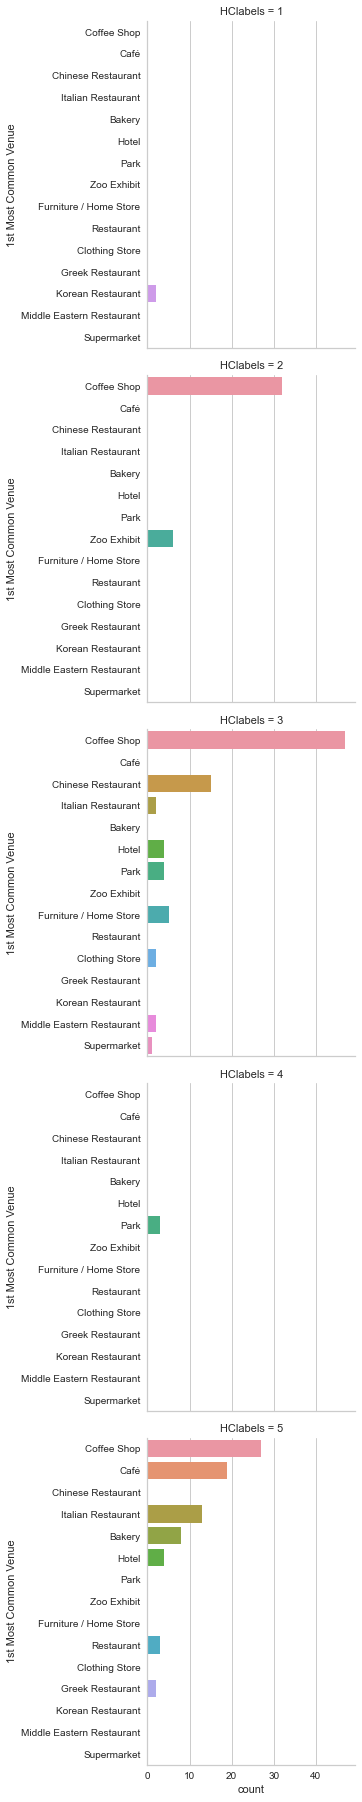

In [282]:
sns.catplot(y='1st Most Common Venue', data = toronto_labels, kind='count', order=df_lt.index, row='HClabels')

In [254]:
toronto_labels['HClabels'] = toronto_labels['HClabels'].astype('int')
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_labels['Latitude'], toronto_labels['Longitude'], toronto_labels['Neighbourhood'], toronto_labels['HClabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The resulting cluster are quite similar to the ones generated by kmeans.